In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
import pandas as pd
from PIL import Image
import numpy as np


# define the dataset
class FlowerDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        img_path = self.root_dir + img_name
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# define the transforms
transform_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(p = 1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),  # convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize the image
])

ttransform = transforms.Compose([
    transforms.RandomCrop((256,256)),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),  # convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize the image
])

# create the dataset and data loaders
train_dataset_tf = FlowerDataset('/kaggle/input/com3025-2023-challenge1/train.csv', '/kaggle/input/com3025-2023-challenge1/', transform_train)
train_dataset = FlowerDataset('/kaggle/input/com3025-2023-challenge1/train.csv', '/kaggle/input/com3025-2023-challenge1/', train_transforms)
train_dataset_crop = FlowerDataset('/kaggle/input/com3025-2023-challenge1/train.csv', '/kaggle/input/com3025-2023-challenge1/', ttransform)
combined_dataset = ConcatDataset([train_dataset, train_dataset_tf, train_dataset_crop])
# define the indices for train/validation split
num_train = len(combined_dataset)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

# shuffle the indices
np.random.shuffle(indices)

# define the train/validation samplers
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create the data loaders for train/validation
train_loader = DataLoader(combined_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(combined_dataset, batch_size=32, sampler=valid_sampler)

In [2]:
print(len(train_loader))

153


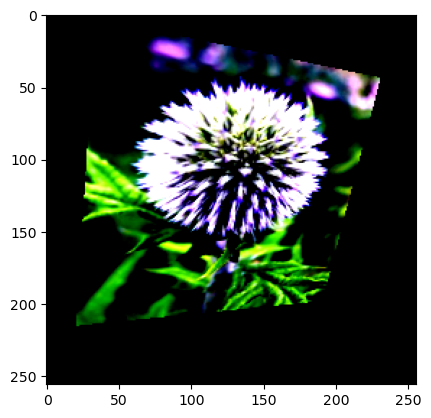

9


In [3]:
import matplotlib.pyplot
image, label = train_dataset_tf[1111]
matplotlib.pyplot.imshow(image.permute(1,2,0))
matplotlib.pyplot.show()
print(label)

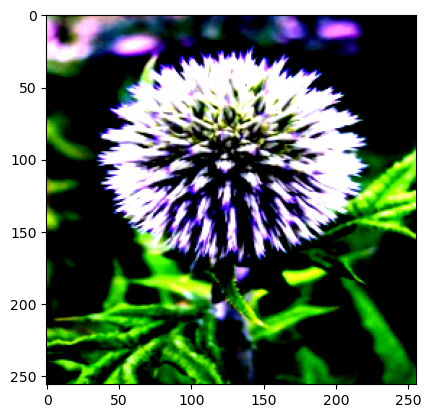

9


In [4]:
image, label = train_dataset[1111]
matplotlib.pyplot.imshow(image.permute(1,2,0))
matplotlib.pyplot.show()
print(label)

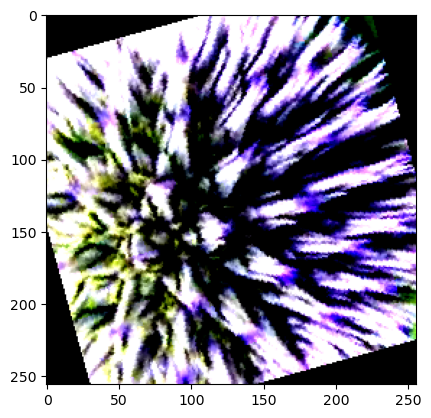

9


In [5]:
image, label = train_dataset_crop[1111]
matplotlib.pyplot.imshow(image.permute(1,2,0))
matplotlib.pyplot.show()
print(label)

In [6]:
# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torchvision.models as models

#model = models.resnet50(pretrained=True)

Weights = models.RegNet_Y_32GF_Weights.IMAGENET1K_SWAG_E2E_V1
model = models.regnet_y_32gf(weights=Weights)
# Replace the last fully connected layer to fit your number of classes
num_classes = 102
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Train the model
for epoch in range(50):
    # train phase
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        if i % 100 == 152:    # print every 63 mini-batches
            print('[Epoch %d, Batch %5d] Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, i + 1, running_loss / 100, 100. * correct / total, correct, total))
            running_loss = 0.0
            correct = 0
            total = 0
    # validation phase
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    print('[Epoch %d] Val Loss: %.3f | Val Acc: %.3f%% (%d/%d)' %
          (epoch + 1, running_loss / len(val_loader), 100. * correct / total, correct, total))

Downloading: "https://download.pytorch.org/models/regnet_y_32gf_swag-04fdfa75.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_32gf_swag-04fdfa75.pth


  0%|          | 0.00/554M [00:00<?, ?B/s]

[Epoch 1] Val Loss: 0.159 | Val Acc: 96.650% (1183/1224)
[Epoch 2] Val Loss: 0.089 | Val Acc: 97.386% (1192/1224)
[Epoch 3] Val Loss: 0.080 | Val Acc: 97.631% (1195/1224)
[Epoch 4] Val Loss: 0.071 | Val Acc: 98.039% (1200/1224)
[Epoch 5] Val Loss: 0.062 | Val Acc: 98.366% (1204/1224)
[Epoch 6] Val Loss: 0.052 | Val Acc: 98.938% (1211/1224)
[Epoch 7] Val Loss: 0.092 | Val Acc: 97.059% (1188/1224)
[Epoch 8] Val Loss: 0.078 | Val Acc: 98.121% (1201/1224)
[Epoch 9] Val Loss: 0.050 | Val Acc: 98.693% (1208/1224)
[Epoch 10] Val Loss: 0.045 | Val Acc: 98.856% (1210/1224)
[Epoch 11] Val Loss: 0.053 | Val Acc: 98.529% (1206/1224)
[Epoch 12] Val Loss: 0.048 | Val Acc: 98.693% (1208/1224)
[Epoch 13] Val Loss: 0.051 | Val Acc: 98.366% (1204/1224)
[Epoch 14] Val Loss: 0.070 | Val Acc: 98.039% (1200/1224)
[Epoch 15] Val Loss: 0.047 | Val Acc: 98.529% (1206/1224)
[Epoch 16] Val Loss: 0.059 | Val Acc: 98.121% (1201/1224)
[Epoch 17] Val Loss: 0.050 | Val Acc: 98.529% (1206/1224)
[Epoch 18] Val Loss: 0.

In [7]:
"""
# define the device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define the model and move it to the device
model = FlowerCNN().to(device)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# train the model
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 50:    # print every 63 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
"""

"\n# define the device to train on\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\n# define the model and move it to the device\nmodel = FlowerCNN().to(device)\n\n# define the loss function and optimizer\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.01)\n\n# train the model\nfor epoch in range(20):\n    running_loss = 0.0\n    for i, data in enumerate(train_loader, 0):\n        inputs, labels = data\n        inputs, labels = inputs.to(device), labels.to(device)\n        optimizer.zero_grad()\n        outputs = model(inputs)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n        if i % 100 == 50:    # print every 63 mini-batches\n            print('[%d, %5d] loss: %.3f' %\n                  (epoch + 1, i + 1, running_loss / 100))\n            running_loss = 0.0\n"

In [8]:
import os
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# set the directory paths for the test images and csv file
test_dir = '/kaggle/input/com3025-2023-challenge1/test'
csv_path = '/kaggle/working/submission.csv'

# create a list to store the results
results = []

# loop through the test images and make predictions
for filename in os.listdir(test_dir):
    if filename.endswith('.jpg'):
        # open the image and apply the transforms
        img_path = os.path.join(test_dir, filename)
        img = Image.open(img_path)
        img = transform(img)
        img = img.unsqueeze(0) # add a batch dimension
        
        # move the input tensor to the same device as the model's parameters
        img = img.to(device)
        
        # make a prediction
        with torch.no_grad():
            output = model(img)
            _, predicted = torch.max(output.data, 1)
            label = predicted.item()
        directoryfile = 'test/' + filename
        # append the result to the list
        results.append((directoryfile, label))

# save the results to a csv file
df = pd.DataFrame(results, columns=['file_path', 'label'])
df.to_csv(csv_path, index=False)